<a href="https://colab.research.google.com/github/djdtimit/Deep-Learning/blob/master/visualizing_what_convnets_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing what convnets learn

convnets are not blackboxes

techniques for visualizing and interpretation:

- Visualizing intermediate convnet outputs (intermediate activations)

- Visualizing convnets filters

- Visualizing heatmaps of class activation in an image

## Visualizing intermediate activations

displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input => visualize these features maps by independently plotting the contents of every channel since every channel encodes relatively independent features

In [0]:
import os
from keras.models import load_model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/dogs_vs_cats/cats_and_dogs_small'

In [0]:
model = load_model(os.path.join(base_dir, 'cats_and_dogs_small_h2.h5'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

### Preprocessing a single image

In [0]:
img_path = os.path.join(base_dir, 'test/cats/cat.1700.jpg')

In [0]:
from keras.preprocessing import image # preprocesses the image into a 4D tensor

In [0]:
import numpy as np

In [0]:
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [0]:
print(img_tensor.shape)

(1, 150, 150, 3)


### Displaying the test picture

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

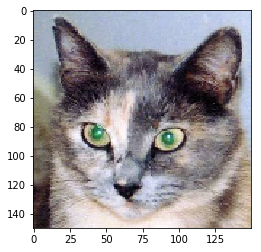

In [0]:
plt.imshow(img_tensor[0])
plt.show()

### Instantiating a model from an input tensor and a list of output tensors

to extract the feature maps, create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers

In [0]:
from keras import models

In [0]:
layer_outputs = [layer.output for layer in model.layers[:8]] # extracts the outputs of the top eight layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # creates a model that will return these outputs, given the model input

When fed an image input, this model returns the values of the layer activations in the original model

### Running the model in predict mode

In [0]:
activations = activation_model.predict(img_tensor) # returns a list of eight numpy arrays: one array per layer activation

In [0]:
len(activations)

8

In [0]:
first_layer_activation = activations[0]

In [0]:
print(first_layer_activation.shape) # 148 x 148 feature map with 32 channels

(1, 148, 148, 32)


### Visualizing the fourth channel

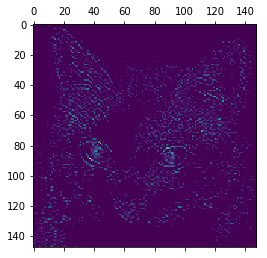

In [0]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

### Visualizing the first channel

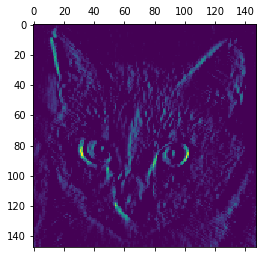

In [0]:
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis') # eye detector

### Visualizing every channel in every intermediate activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


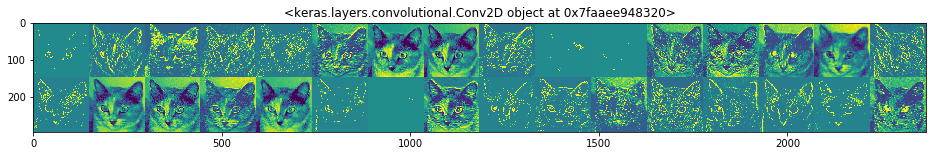

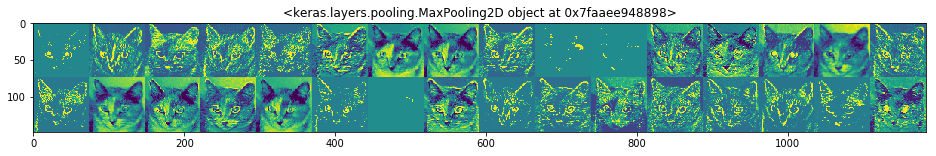

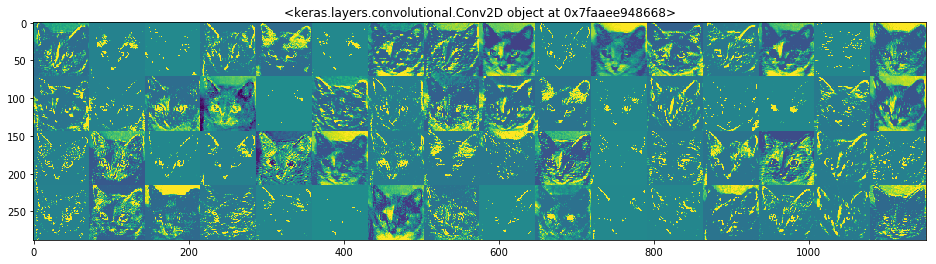

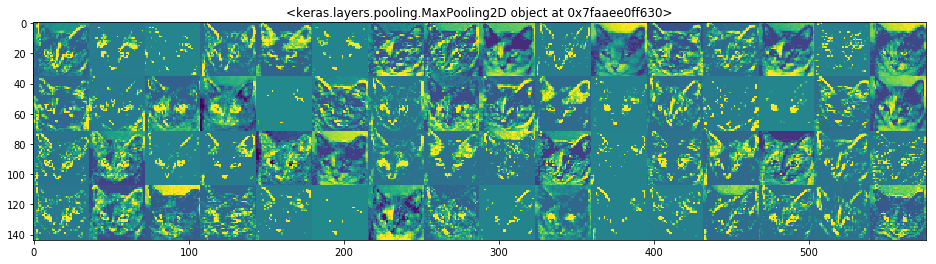

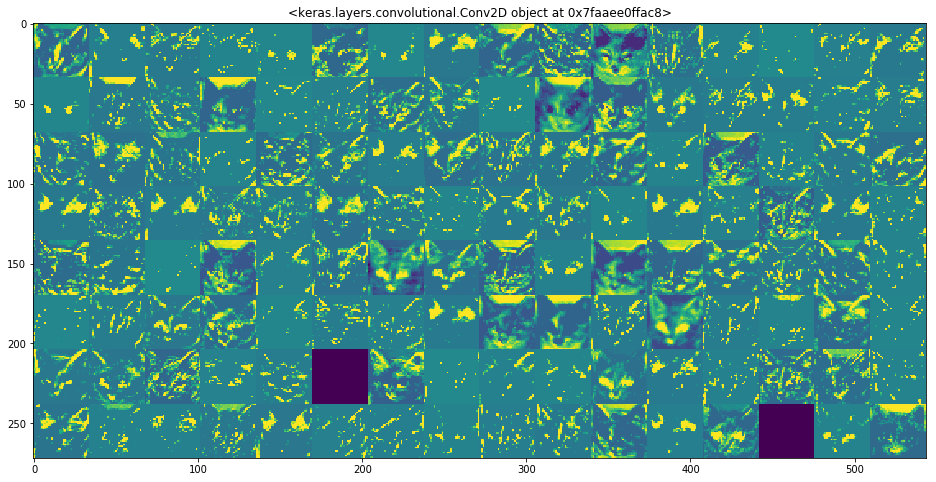

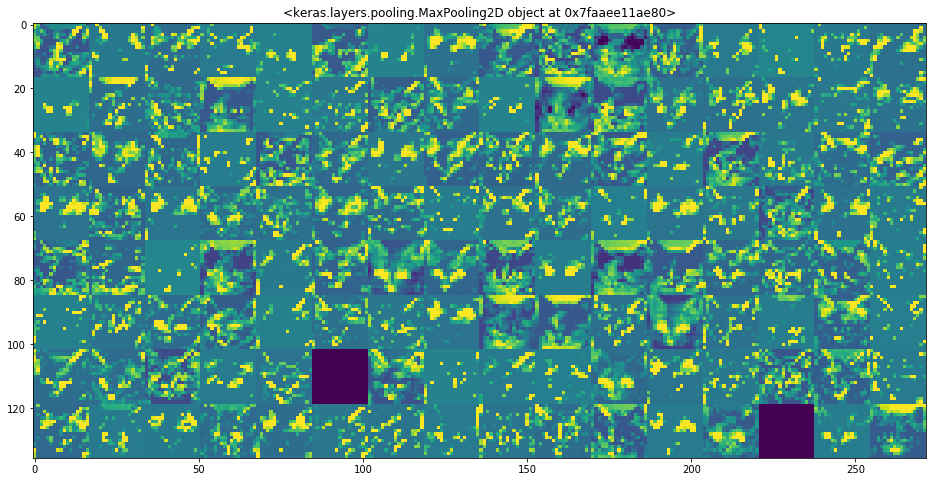

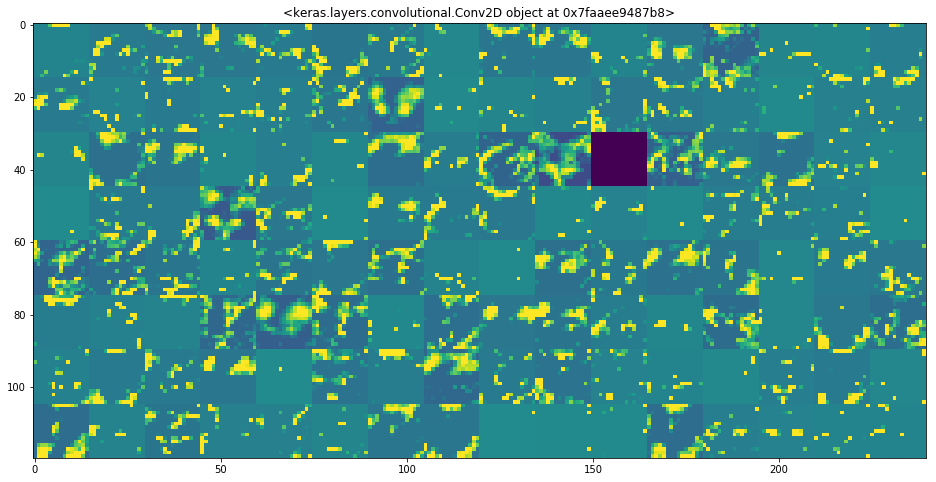

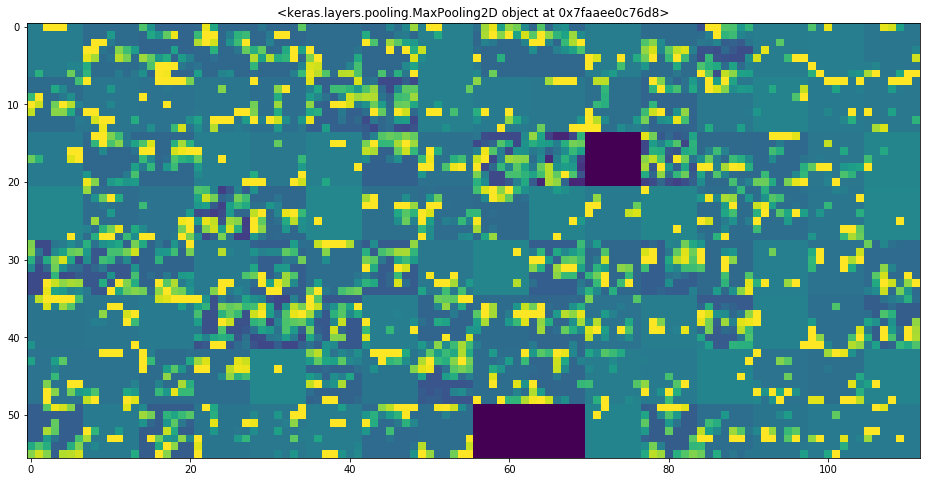

In [0]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1] # number of features in the feature map 

  size = layer_activation.shape[1] # this feature map has shape (i, size, size, n_features)

  n_cols = n_features // images_per_row # tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row): # tiles each filter into a big horizontal grid
      channel_image = layer_activation[0,:,:,col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image # display the grid

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

There are a few things to note here:
- The first layer acts as a collection of various edge detectors. At that stage, the
activations retain almost all of the information present in the initial picture.
- As you go higher, the activations become increasingly abstract and less visually
interpretable. They begin to encode higher-level concepts such as “cat ear” and
“cat eye.” Higher presentations carry increasingly less information about the
visual contents of the image, and increasingly more information related to the
class of the image.
- The sparsity of the activations increases with the depth of the layer: in the first
layer, all filters are activated by the input image; but in the following layers,
more and more filters are blank. This means the pattern encoded by the filter
isn’t found in the input image.

We have just evidenced an important universal characteristic of the representations
learned by deep neural networks: the features extracted by a layer become increas-
ingly abstract with the depth of the layer. The activations of higher layers carry less
and less information about the specific input being seen, and more and more infor-
mation about the target (in this case, the class of the image: cat or dog). A deep neu-
ral network effectively acts as an information distillation pipeline, with raw data going in
(in this case, RGB pictures) and being repeatedly transformed so that irrelevant infor-
mation is filtered out (for example, the specific visual appearance of the image), and
useful information is magnified and refined (for example, the class of the image).

## Visualizing convnet filters

Another easy way to inspect the filters learned by convnets is to display the visual pat-
tern that each filter is meant to respond to. This can be done with gradient ascent in
input space: applying gradient descent to the value of the input image of a convnet so as
to maximize the response of a specific filter, starting from a blank input image. The
resulting input image will be one that the chosen filter is maximally responsive to.
The process is simple: you’ll build a loss function that maximizes the value of a
given filter in a given convolution layer, and then you’ll use stochastic gradient
descent to adjust the values of the input image so as to maximize this activation value.
For instance, here’s a loss for the activation of filter 0 in the layer block3_conv1 of the
VGG16 network, pretrained on ImageNet.

### Defining the loss tensor for filter visualization

In [0]:
from keras.applications import VGG16
from keras import backend as K

In [0]:
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output 
loss = K.mean(layer_output[:,:,:, filter_index])





58892288/58889256 [==============================] - 6s 0us/step








### Obtaining the gradient of the loss with regard to the input

In [0]:
grads = K.gradients(loss, model.input)[0]

### Gradient-normalization trick

In [0]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

### Fetching Numpy output values given Numpy input values

In [0]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

### Loss maximization via stochastic gradient descent

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_image_data])

  input_img_data += grads_value * step

### Utility function to convert a tensor into a valid image

In [0]:
def deprocess_image(x):
  x -=x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Function to generate filter visualizations

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

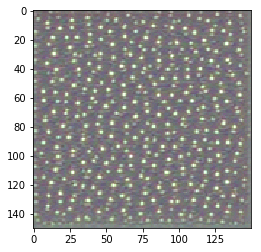

In [0]:
plt.imshow(generate_pattern('block3_conv1', 0))

### Generating a grid of all filter response patterns in a layer

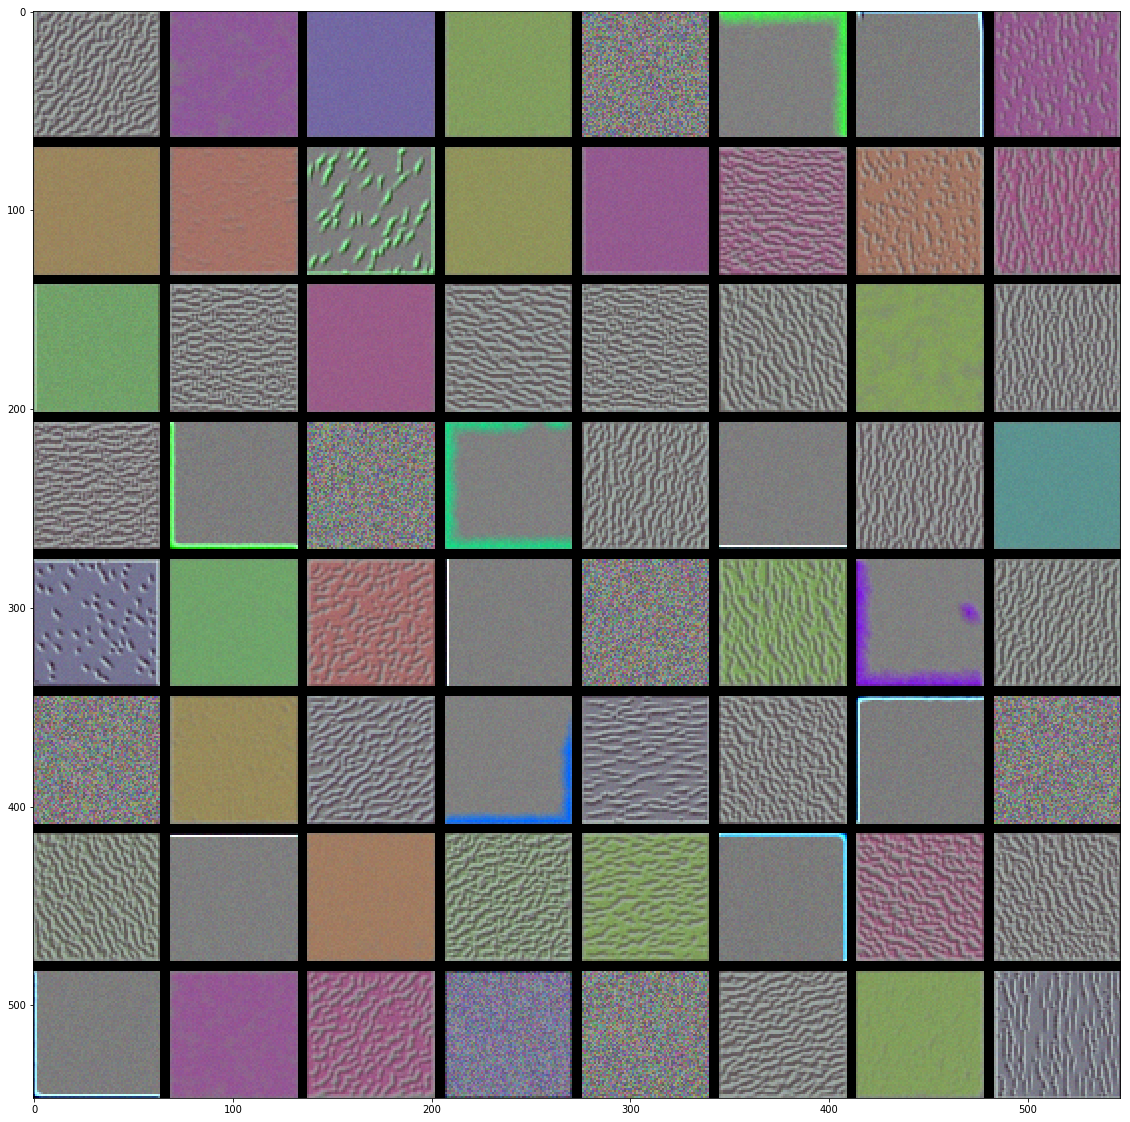

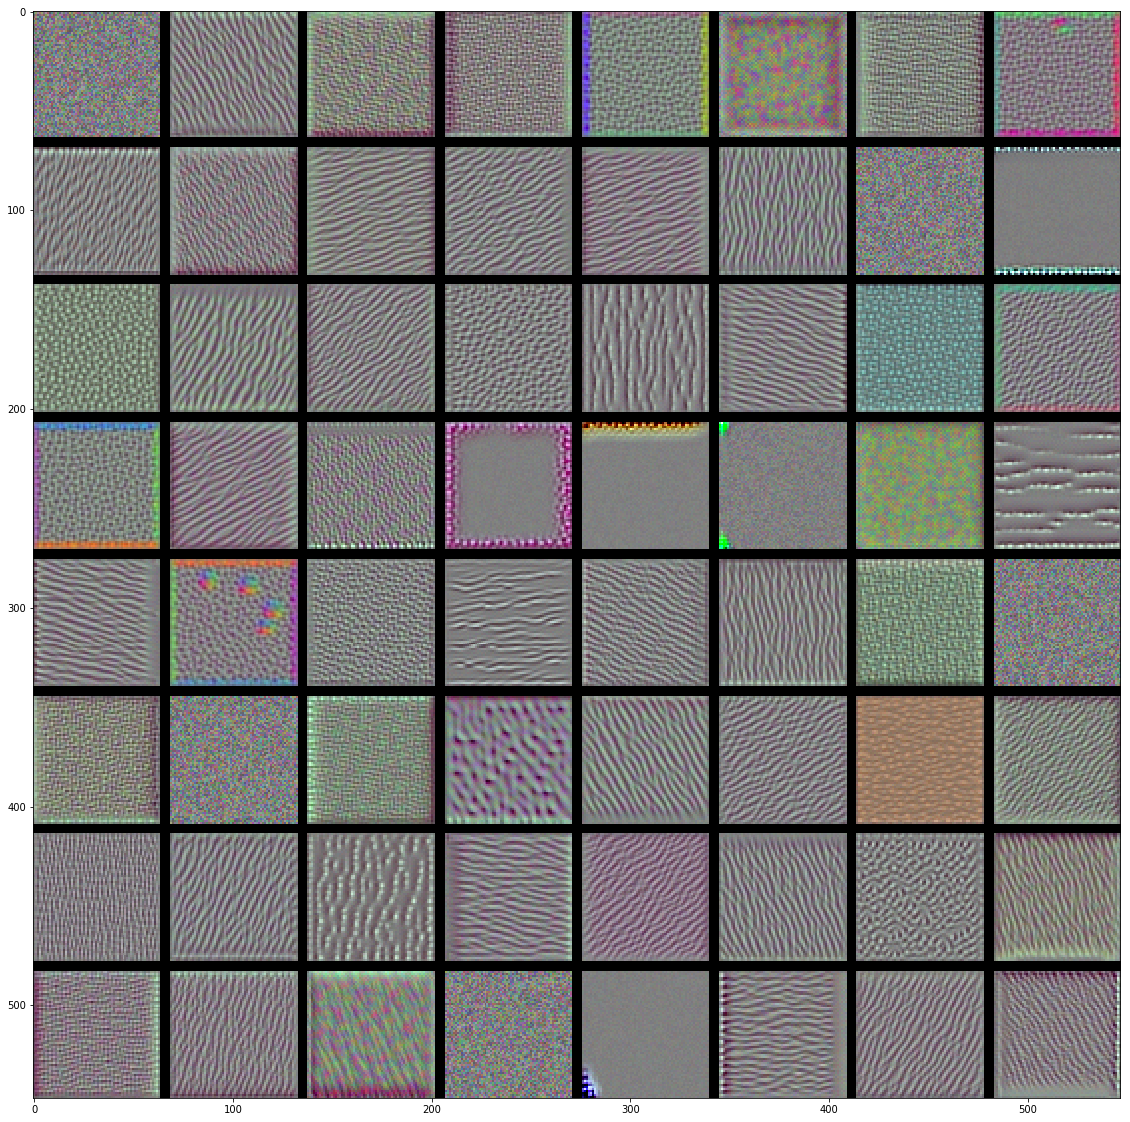

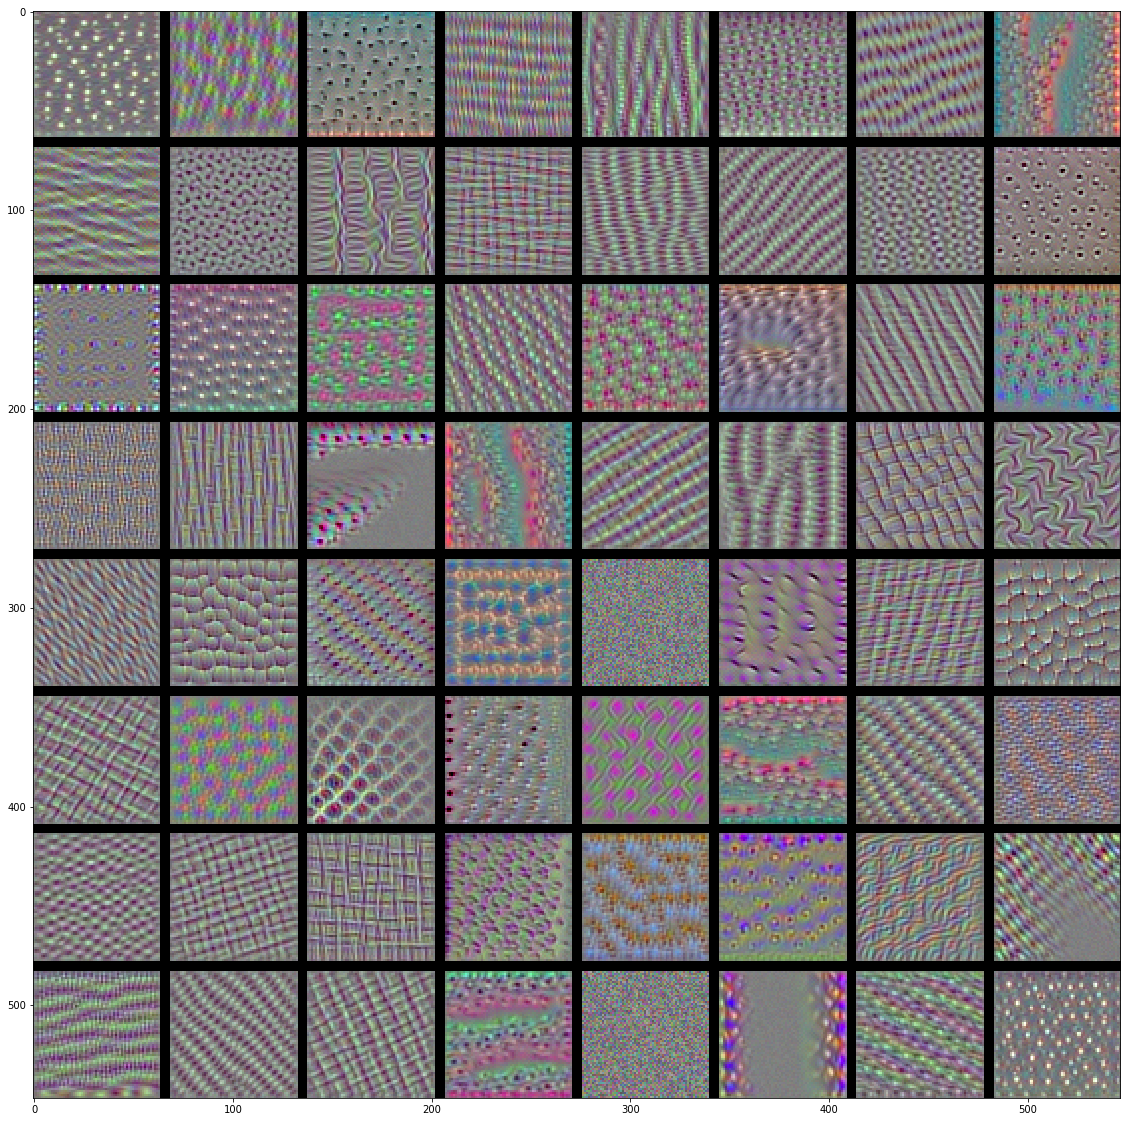

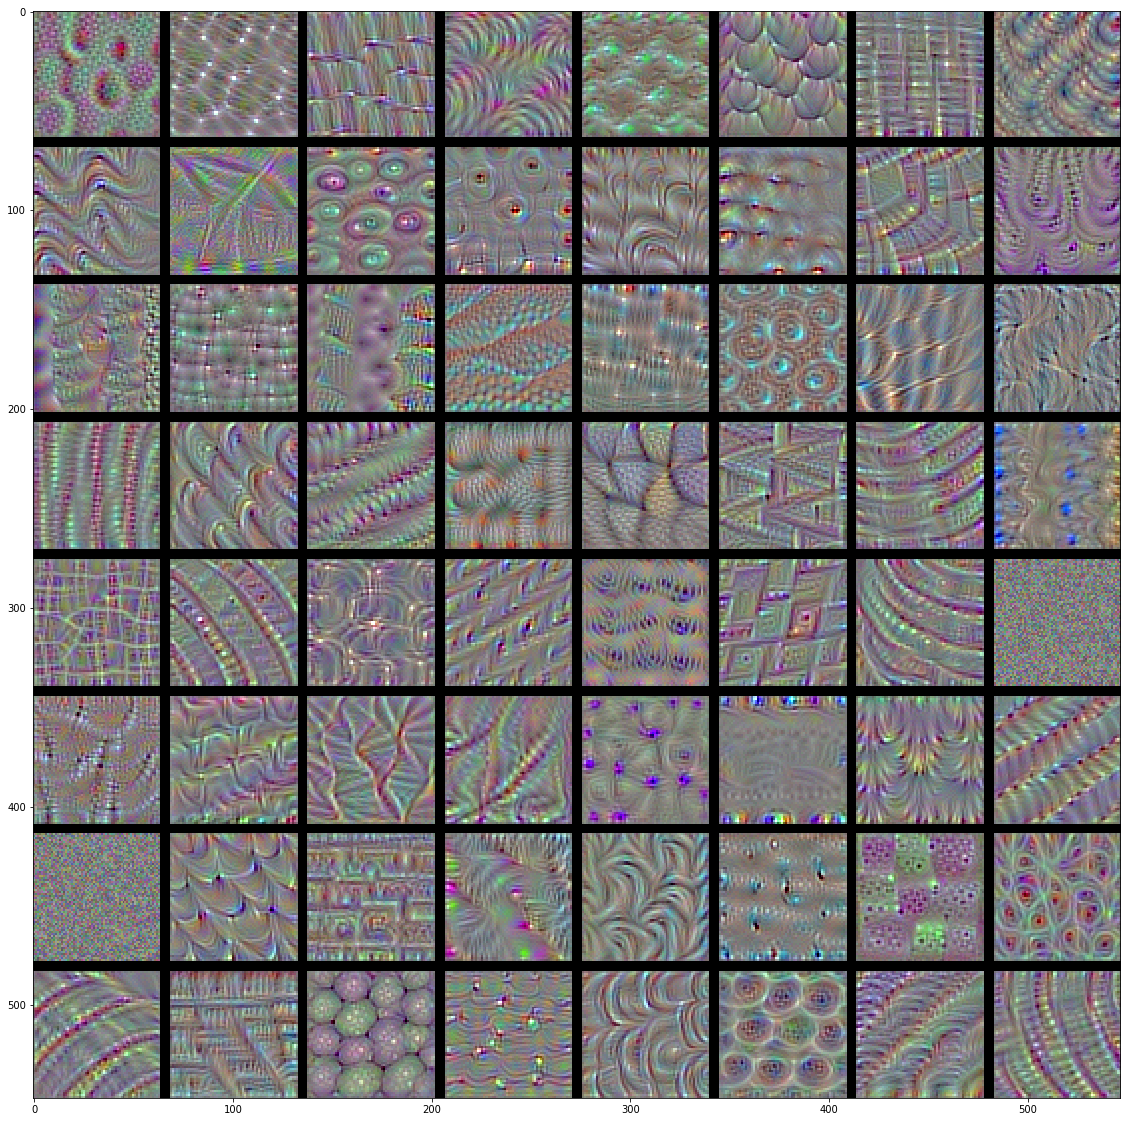

In [0]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.astype(np.uint8))
    plt.show()

These filter visualizations tell you a lot about how convnet layers see the world: each
layer in a convnet learns a collection of filters such that their inputs can be expressed
as a combination of the filters. This is similar to how the Fourier transform decom-
poses signals onto a bank of cosine functions. The filters in these convnet filter banks
get increasingly complex and refined as you go higher in the model:
- The filters from the first layer in the model (block1_conv1) encode simple
directional edges and colors (or colored edges, in some cases).

- The filters from block2_conv1 encode simple textures made from combina-
tions of edges and colors.

- The filters in higher layers begin to resemble textures found in natural images:
feathers, eyes, leaves, and so on.

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".



In [1]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Using TensorFlow backend.






553467904/553467096 [==============================] - 16s 0us/step








The model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

### Preprocessing an input image for VGG16

In [0]:
from keras.preprocessing import image 
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
img_path = '/content/gdrive/My Drive/Colab Notebooks'

In [0]:
img = image.load_img(os.path.join(img_path, 'creative_commons_elephant.jpg'), target_size=(224,224))

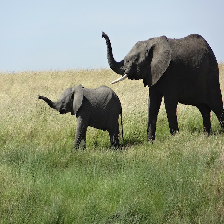

In [14]:
img

In [0]:
x = image.img_to_array(img)

In [0]:
x = np.expand_dims(x, axis=0)

In [0]:
x = preprocess_input(x)

In [0]:
preds = model.predict(x)

In [23]:
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.0043545896)]


The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

### Setting up the Grad-CAM algorithm

In [0]:
african_elephant_output = model.output[:, 386]

In [0]:
last_conv_layer = model.get_layer('block5_conv3')

In [0]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

In [0]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [0]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [0]:
for i in range(512):
  conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)

### Heatmap post-processing

In [0]:
heatmap = np.maximum(heatmap, 0)

In [0]:
heatmap /= np.max(heatmap)

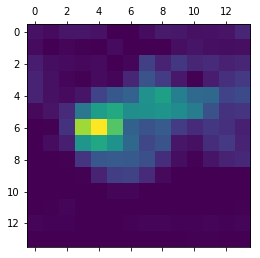

In [41]:
plt.matshow(heatmap)

### Superimposing the heatmap with the original picture

In [0]:
import cv2

In [0]:
img = cv2.imread(os.path.join(img_path, 'creative_commons_elephant.jpg'))

In [0]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [0]:
heatmap = np.uint8(255 * heatmap)

In [0]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [0]:
superimposed_img = heatmap * 0.4 + img

In [50]:
cv2.imwrite(os.path.join(img_path, 'elephant_cam.jpg'), superimposed_img)

True

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.
